# pyg.timeseries.ewma

The ewm functions implement the concept of time which we think is worthwhile explaining. We start with an example

<AxesSubplot:>

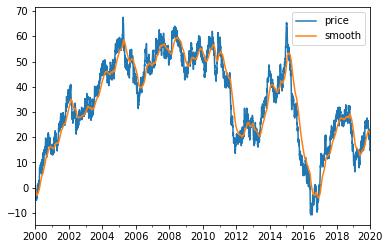

In [1]:
from pyg import *; import numpy as np; import pandas as pd
rtn = pd.Series(np.random.normal(0.01,1,5218), drange(2000,2020, '1b'))
price = cumsum(rtn); price.name = 'price'
smooth = ewma(price, 50); smooth.name = 'smooth'
pd.concat([price, smooth], axis = 1).plot()

<AxesSubplot:>

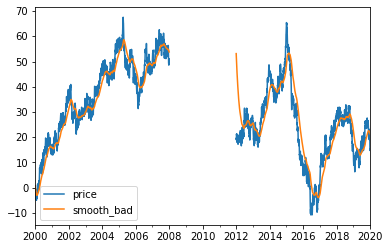

In [2]:
## now suppose somewhow we lost 4 years of data...
bad = price.copy()
bad[dt(2008):dt(2012)] = np.nan
smooth_bad = ewma(bad, 50); smooth_bad.name = 'smooth_bad'
pd.concat([bad, smooth_bad], axis = 1).plot()

<AxesSubplot:>

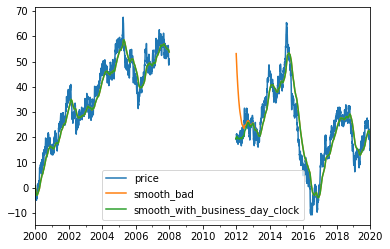

In [8]:
smooth_with_time = ewma(bad, 50, time = 'b')
smooth_with_time.name = 'smooth_with_business_day_clock'
pd.concat([bad, smooth_bad, smooth_with_time], axis = 1).plot()

What happened here? How can smooth with clock track better?
<br> The answer is that if you provide a clock, ewma can recognise that 4 years have passed. 
<br> The old data is irrelevant, it forgets the old position and start with most of the weight on the more recent observations 

## What happens if the clock does not move at all?

Suppose we now choose to calculate daily ewma but we are doing this with intraday data. If the number of data points per day is constant and known, then this can be done with ease. 
<br> Using time parameter, we can do this even for an irregularly spaced timeseries. We first just create some fake data:

<AxesSubplot:>

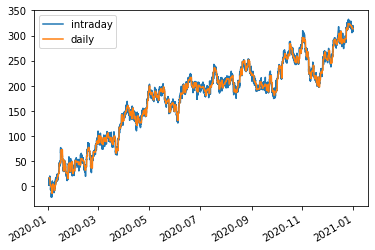

In [4]:
import datetime
bar = datetime.timedelta(minutes = 5)
all_bars = [t for t in drange(2020, 2021, bar)]
ts = pd.Series(np.random.normal(0.01/24, 1, len(all_bars)), all_bars)
price = cumsum(ts); price.name = 'intraday'

bars = np.array([t for t in drange(2020, 2021, bar) if t.hour>=8 and t.hour<=17]) ## trading hours
irregular = bars[np.random.normal(0,1,len(bars))>0]  

ts = pd.Series(np.random.normal(0.01/24, 1, len(bars)), bars)
price = cumsum(ts); price.name = 'intraday'
price = price[irregular] ## remove half the bars randomly

days = drange(2020,2021,1)

daily = price.reindex(days, method = 'ffill'); daily.name = 'daily'
pd.concat([price, daily], axis = 1).ffill().plot()

* By setting clock to **d**aily we tell ewma that all the hourly data in the same day are 'on same clock'. And it will use historic end-of-day prices while updating today the last point until the cloc moves to tomorrow's reading
* If we set the clock to **f**raction, it will update continuously throuout the day

<AxesSubplot:>

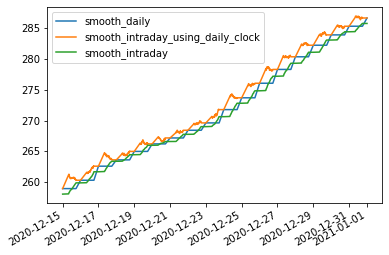

In [5]:
smooth_intra = ewma(price, 20, 'f'); smooth_intra.name = 'smooth_intraday' ## roughly matching using irregular bars
smooth_intra_using_d = ewma(price, 20, time = 'd'); smooth_intra_using_d.name = 'smooth_intraday_using_daily_clock'
smooth_daily = ewma(daily, 20); smooth_daily.name = 'smooth_daily'
pd.concat([smooth_daily, smooth_intra_using_d, smooth_intra], axis = 1).ffill()[dt(2020,12,15):].plot()

* smooth_daily is calculated on daily basis and is constant within the day and experiences jumps on EOD
* time = 'd' option front-runs daily, but at the price of being more volatile intra-day. On end-of-day the two version aggree
* time = 'f' is a smoother version of daily. It is leading, but not by much

In [7]:
pd.concat([smooth_intra_using_d.reindex(days, method = 'ffill'), smooth_daily], axis = 1)
## on end-of-day we have an exact match between time = 'd' and daily smooth

,smooth_intraday_using_daily_clock,smooth_daily
2020-01-01,NaN,NaN
2020-01-02,16.752182,16.752182
2020-01-03,9.725194,9.725194
2020-01-04,5.864732,5.864732
2020-01-05,0.578778,0.578778
...,...,...
2020-12-28,280.375383,280.375383
2020-12-29,282.254090,282.254090
2020-12-30,283.934041,283.934041
2020-12-31,285.343263,285.343263


## What are valid time parameters?


* None: If None is provided, any (non-nan) observation is considered to be a clock ticking 
* i: index of timeseries. The clock ticks also for nan observations. This is the default for pandas
* f: fraction of day
* b/d/w/m/q/y: business day/daily/weekly/monthly/quarterly or yearly
* Calendar: the business day as defined by the calendar provided  
* For full control, you can provide a timeseries of non-decreasing times matching the original array